In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Neural Network
from sklearn.neural_network import MLPClassifier

In [301]:
df = pd.read_csv("Food_Delivery_Time_Prediction.csv")
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [302]:
def extract_lat_long(location):
    lat, lon = location.strip("()").split(",")
    return float(lat), float(lon)

df[["Cust_Lat", "Cust_Lon"]] = df["Customer_Location"].apply(
    lambda x: pd.Series(extract_lat_long(x))
)

df[["Rest_Lat", "Rest_Lon"]] = df["Restaurant_Location"].apply(
    lambda x: pd.Series(extract_lat_long(x))
)

In [303]:
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

df["Haversine_Distance"] = df.apply(
    lambda row: haversine(row["Cust_Lat"], row["Cust_Lon"],
                          row["Rest_Lat"], row["Rest_Lon"]),
    axis=1
)

In [304]:
df["Rush_Hour"] = df["Order_Time"].apply(
    lambda x: 1 if x in ["Morning", "Evening"] else 0
)

In [305]:
threshold = df["Delivery_Time"].median()
df["Delivery_Status"] = np.where(df["Delivery_Time"] > threshold, 1, 0)

In [306]:
df.drop(columns=["Order_ID", "Customer_Location", "Restaurant_Location", "Delivery_Time"], inplace=True)

# Encode categorical variables
le = LabelEncoder()
for col in df.select_dtypes(include=["object", "string"]):
        df[col] = le.fit_transform(df[col])

In [307]:
X = df.drop("Delivery_Status", axis=1)
y = df["Delivery_Status"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

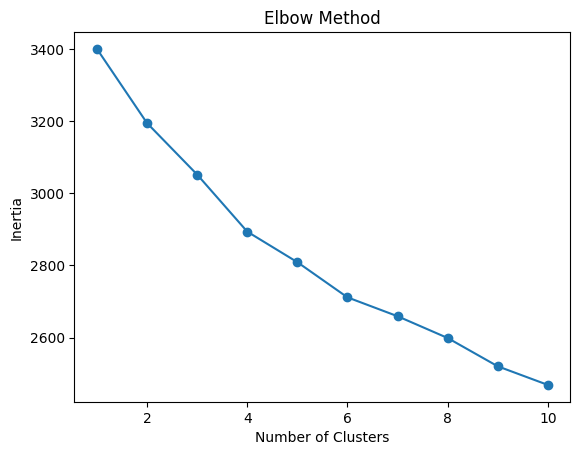

In [308]:
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [309]:
kmeans = KMeans(n_clusters=3, random_state=42)
df["KMeans_Cluster"] = kmeans.fit_predict(X_scaled)
# cluster
cluster_analysis = df.groupby("KMeans_Cluster")[["Haversine_Distance", "Traffic_Conditions", "Delivery_Status"]].mean()
cluster_analysis

,Haversine_Distance,Traffic_Conditions,Delivery_Status
KMeans_Cluster,,,
0,615.248584,1.195122,0.487805
1,682.357870,0.703125,0.468750
2,490.486954,1.370370,0.555556


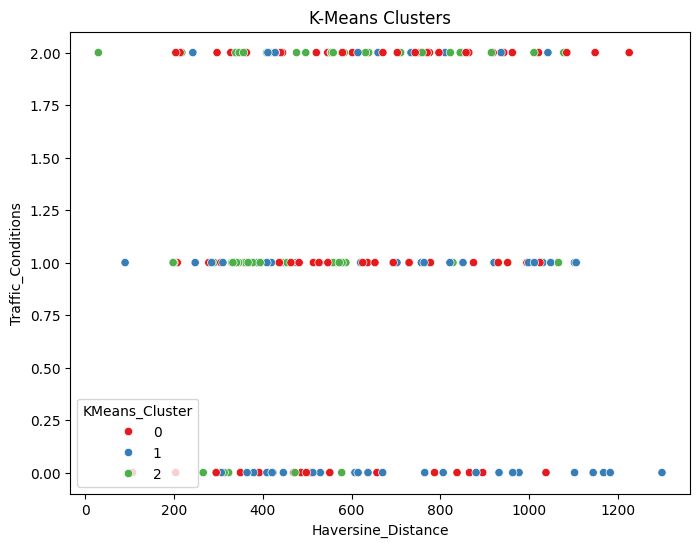

In [310]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df["Haversine_Distance"], 
                y=df["Traffic_Conditions"], 
                hue=df["KMeans_Cluster"], palette="Set1")
plt.title("K-Means Clusters")
plt.show()

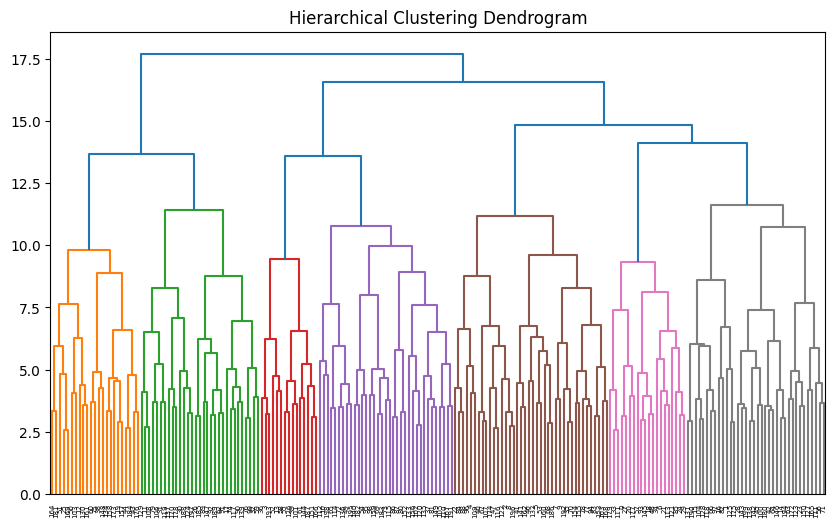

In [311]:
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(10,6))
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

In [312]:
agg = AgglomerativeClustering(n_clusters=3)
df["Hierarchical_Cluster"] = agg.fit_predict(X_scaled)

In [313]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [314]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (32,16), (64,32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001]
}

grid_mlp = GridSearchCV(
    MLPClassifier(
    max_iter=2000,
    early_stopping=True,
    random_state=42
),
    param_grid,
    cv=3
)

grid_mlp.fit(X_train, y_train)

best_mlp = grid_mlp.best_estimator_
y_pred_nn = best_mlp.predict(X_test)

print("Best Parameters:", grid_mlp.best_params_)

y_prob_nn = best_mlp.predict_proba(X_test)[:,1]

print("Neural Network Results")
print("Accuracy:", accuracy_score(y_test, y_pred_nn))
print("Precision:", precision_score(y_test, y_pred_nn))
print("Recall:", recall_score(y_test, y_pred_nn))
print("F1 Score:", f1_score(y_test, y_pred_nn))
print("AUC:", roc_auc_score(y_test, y_prob_nn))

Best Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (32, 16)}
Neural Network Results
Accuracy: 0.55
Precision: 0.5483870967741935
Recall: 0.8095238095238095
F1 Score: 0.6538461538461539
AUC: 0.4210526315789474


In [315]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.575


In [316]:
comparison = pd.DataFrame({
    "Model": ["Neural Network", "Logistic Regression"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_nn),
        accuracy_score(y_test, y_pred_lr)
    ]
})

comparison

,Model,Accuracy
0,Neural Network,0.550
1,Logistic Regression,0.575


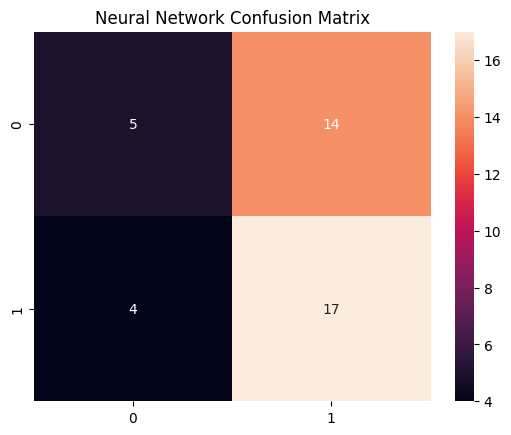

In [317]:
cm = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Neural Network Confusion Matrix")
plt.show()

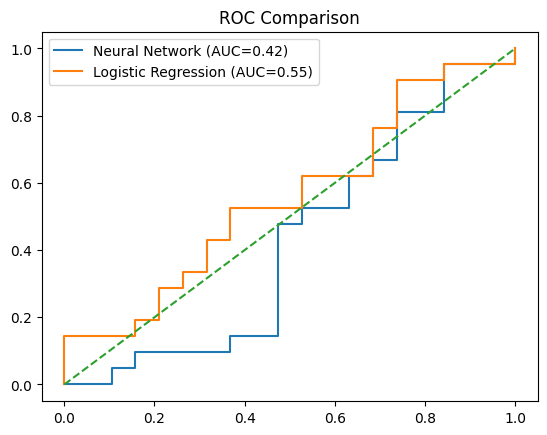

In [318]:
y_prob_lr = log_reg.predict_proba(X_test)[:,1]

for name, y_prob in [("Neural Network", y_prob_nn),
                     ("Logistic Regression", y_prob_lr)]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")

plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Comparison")
plt.show()

# Food Delivery Time Prediction  
## Clustering and Neural Network Analysis

---

## Overview

This study applied **K-Means clustering**, **Hierarchical clustering**, **Neural Networks (MLPClassifier)**, and **Logistic Regression** to analyze and predict food delivery delays.

The objective was to classify deliveries as:

- Fast (0)  
- Delayed (1)

Feature engineering included:

- Calculation of Haversine distance  
- Creation of a Rush Hour indicator  
- Standardization of numerical features  

---

## Clustering Analysis

### K-Means Clustering

The Elbow Method was used to determine the optimal number of clusters.  
Based on inertia reduction, three clusters were selected.

### Cluster Insights

| Cluster | Avg Distance | Avg Traffic | Delay Rate |
|----------|-------------|-------------|------------|
| 0 | 615.25 | 1.19 | 48.8% |
| 1 | 682.36 | 0.70 | 46.9% |
| 2 | 490.49 | 1.37 | 55.6% |

### Interpretation

- Cluster 2 shows the **highest traffic levels and highest delay rate**, despite having the shortest average distance.
- Cluster 1 has the **longest distance but lowest traffic**, and the lowest delay rate.

This indicates that **traffic conditions have a stronger impact on delivery delays than distance alone**.

---

### Hierarchical Clustering

Agglomerative clustering was applied and visualized using a dendrogram.

Results supported similar segmentation patterns as K-Means, reinforcing that:

- Traffic conditions  
- Delivery distance  

are the primary structural factors influencing delivery performance.

---

## Neural Network Model

A Feedforward Neural Network (MLPClassifier) was implemented and tuned using GridSearchCV.

### Best Hyperparameters Identified

- Hidden layers: (32, 16)  
- Activation function: ReLU  
- Regularization (alpha): 0.0001  
- Early stopping enabled  
- Maximum iterations: 2000  

### Neural Network Performance

- Accuracy: 55%  
- Precision: 0.548  
- Recall: 0.810  
- F1 Score: 0.654  
- AUC: 0.421  

The Neural Network achieved strong recall, meaning it correctly identified most delayed deliveries. However, the AUC value indicates weaker probability discrimination capability.

---

## Logistic Regression Model

Logistic Regression was implemented as a baseline linear classifier.

### Performance

- Accuracy: 57.5%

Logistic Regression achieved higher overall accuracy compared to the Neural Network.

---

## Model Comparison

| Model | Accuracy |
|--------|----------|
| Neural Network | 55% |
| Logistic Regression | 57.5% |

Although the Neural Network achieved higher recall and F1-score, Logistic Regression achieved higher overall accuracy (57.5%) and demonstrated more stable discrimination performance.

Therefore, Logistic Regression is selected as the better-performing model for this dataset.

The results suggest that the dataset may not contain strong nonlinear patterns, and simpler linear models may generalize more effectively.

---

## Business Insights

- High traffic congestion significantly increases delivery delays.
- Distance alone does not strongly determine delays.
- Rush-hour periods increase delay probability.
- Managing traffic-related risks can improve delivery reliability.
- Assigning experienced drivers to high-traffic zones may reduce delays.

---

## Conclusion

Clustering analysis revealed meaningful segmentation patterns, highlighting traffic conditions as the primary driver of delivery delays.

While Neural Networks showed strong recall performance, Logistic Regression achieved better overall accuracy and more stable generalization.

For this dataset, a simpler linear model proved more effective than a nonlinear neural network.

Logistic Regression is therefore recommended for deployment in predicting delivery delays.